# Inefficient Operator Identification for CallMeMaybe
Guy Zamir, April 2021
## Goal
CallMeMaybe, a virtual telephony service, wants to improve the quality of their service and then in turn improve customer satisfaction and reduce churn.  



##  What are we doing in order to find inefficient operators? 
One of the things it is doing in order to achieve this goal is to develop a function that will highlight the least effective operators to supervisors. 

* Metrics to look at will be defined as: 
    - Number of missed incoming calls will be defined as is_missed_call = True & direction = 'in'
    - Waiting time for incoming calls will be defined as direction = 'in' & waiting time (total_call_duration minus call_duation) 
    - Number of outgoing calls in case the operator is supposed to make outgoing calls will be defined as the sum of 'calls_count' & at least one value within 'direction' == 'out' 
 
<u> <b> How do we define ineffectiveness of an operator?</b>  </u> <br>
1. Find the score of all operators for each of the metrics. 
2. Divide each metric into tenths and then score each operator based on their rank (1-10) for every metric individually. 
Then, we have options to pick from:
    1. Operator is considered ineffective in case he is in the 10th worst category in either of the metrics.
    2. Avg. the score of each operator for all three metrics and then define ineffective is it is got a score of over 7.5 (25% least effective operators). 
    3. Pick one of the options above with a different sensitivity threshold. 


We choose to go with the second option of avg. within all three metrics and a threshold of 7.5/10
 


## How are we going to achieve it?
1. [Data pre-processing ](#1) <br>
    - download the data
    - validate data types 
    - missing values 
    - duplicates 
    - check correct column names 
2. [Carry out exploratory data analysis](#2)<br>
    - create 'waiting_time' column as 'total_call_duration' minus 'call_duation' 
    - create tables with the 3 following metrics grouped by operator_id:
        - count of missed incoming calls
        - sum of waiting time for incoming calls
        - count of outgoing calls 
    - Merge into a master operator_id table with aggregated data per operator 
    - plot histograms for all 3 metrics 
    - calculate 75th and 90th precentiles for each of the metrics
    - decide if there are anomalies that should be excluded. If needed, duplicate data frame and then remove anomalies. 
3. [Identify ineffective operators](#3)<br>
    - define a function to rank / bin the operators score for each of the metrics as a 1-100 score so that the higher the score the worst the operator is doing in the specific metric. <i> e.g. in the third metric it is more confusing than the others, since the lower the amount of calls the worse the operator is (for those that are supposed to make outgoing calls). In case the operator is not supposed to make such calls, we will avg. them only based on the two first metrics. </i>
    - apply function to our data frame
    - plot 3 histograms to see how many operators fall within each rank (1-100) of the metrics we defined. 
    - decide whether the threshold we agreed upon of 75%+ should stay. For example, if it looks like 50% of the operators are going to be considered ineffective - maybe we should be changing our level of sensitivity and set a higher threshold to be considered as ineffective. 
    - calculate average of each operator for the three metrics (within operators_pivot).  
    - add a column of is_ineffective and set to true all operators with avg. above the agreed upon threshold
    

    
4. [Test statistical hypotheses](#4) 

    - merge original data frame with 'telecom_clients_us' table on the 'user_id' column
    - calculate revenue per call as the sum of 'tariff_plan' * 'call_duration'
    - calculate total revenue per operator in a new pivot data frame. 
    - join this column to the operators pivot we defined in step 2 
    - proposed hypothesis: ineffective operators yield lower total revenue. 
        - H0: mean revenue for ineffective operators and effective ones is similar.
        - H1: mean revenue for ineffective operators is lower than this of effective ones. 
    - conduct normality assumption tests for total revenue data
    - divide total revenue data into ineffective and effective operators 
    - if meets normality assumption, conduct a t-test. Otherwise, conduct a matt-whitney test. 
    - conclusion & propose next steps 

5. [Others](#5)
    - Useful readings

### Data pre-processing
<a id="1"></a>
Import libraries 

In [1]:
import pandas as pd
import numpy as np 
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
# from scipy import stats as st
# import matplotlib.colors as mcolors

Download the data

In [2]:
try:
    data = pd.read_csv('/datasets/telecom_dataset_us.csv')
except:
    try:
        data = pd.read_csv('../datasets/telecom_dataset_us.csv')
    except:
        #directly from Yandex's server
        data = pd.read_csv('https://code.s3.yandex.net//datasets/telecom_dataset_us.csv') 
         
try:
    clients_data = pd.read_csv('/datasets/telecom_clients_us.csv')
except:
    try:
        clients_data = pd.read_csv('../datasets/telecom_clients_us.csv')
    except:
        #directly from Yandex's server
        clients_data = pd.read_csv('https://code.s3.yandex.net//datasets/telecom_clients_us.csv') 
        
#clients_data.head() 
data.head(10)


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62


Validate data types:

In [3]:
data.info()

#date, object -> date 
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S', errors='ignore')

#direction, object -> category
data['direction'] = data['direction'].astype('category')

#internal, object -> bool
data['internal'] = data['internal'].astype('bool')

#operator_id, float -> int 
# data['operator_id'] = data['operator_id'].astype('int')

data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


operator_id can not be converted due to NALs, let's fix them: 

In [4]:
print(data.isna().sum())

print("share of operator nals{: .2f}%".format(data.operator_id.isna().sum() / len(data.operator_id) * 100))

user_id                   0
date                      0
direction                 0
internal                  0
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64
share of operator nals 15.16%


15% of the operator_id values are missing. On one hand they are crucial to our analysis but on the other, we don't have a way to fill them up.  Hence, with a heavy heart we will have to remove them for this analysis. 

In [5]:
data = data.dropna(subset=['operator_id'])

print(data.isna().sum())


user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64


Change data type (as intended before) to int:

In [6]:
#operator_id, float -> int 
data['operator_id'] = data['operator_id'].astype('int')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45730 entries, 1 to 53900
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              45730 non-null  int64                                
 1   date                 45730 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            45730 non-null  category                             
 3   internal             45730 non-null  bool                                 
 4   operator_id          45730 non-null  int64                                
 5   is_missed_call       45730 non-null  bool                                 
 6   calls_count          45730 non-null  int64                                
 7   call_duration        45730 non-null  int64                                
 8   total_call_duration  45730 non-null  int64                                
dtypes: bool

check for duplicates: 

In [7]:
print("sum of duplicates {}".format(data.duplicated().sum()))

print(data[data.duplicated() == True])

data = data.drop_duplicates().reset_index()


sum of duplicates 4184
       user_id                      date direction  internal  operator_id  \
8       166377 2019-08-05 00:00:00+03:00       out     False       880020   
44      166377 2019-08-14 00:00:00+03:00       out     False       880026   
51      166377 2019-08-15 00:00:00+03:00       out     False       880026   
62      166377 2019-08-19 00:00:00+03:00       out     False       880026   
78      166377 2019-08-22 00:00:00+03:00       out     False       880026   
...        ...                       ...       ...       ...          ...   
53861   168601 2019-11-20 00:00:00+03:00       out     False       952914   
53869   168601 2019-11-25 00:00:00+03:00        in     False       952914   
53874   168601 2019-11-26 00:00:00+03:00        in     False       952914   
53885   168603 2019-11-20 00:00:00+03:00       out     False       959118   
53900   168606 2019-11-15 00:00:00+03:00       out      True       957922   

       is_missed_call  calls_count  call_duration  t

column names seem okay. 

### Exploratory data analysis
<a id="2"></a>
create 'waiting_time' column as 'total_call_duration' minus 'call_duation' 

In [8]:
data['waiting_time'] = data['total_call_duration'] - data['call_duration']
data.sample(5)

,index,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
15278,20030,166997,2019-09-26 00:00:00+03:00,in,False,905430,False,3,608,625,17
1650,2083,166406,2019-10-14 00:00:00+03:00,out,False,879896,True,1,0,2,2
11387,15045,166884,2019-08-27 00:00:00+03:00,out,False,895776,False,1,93,104,11
21455,28036,167176,2019-11-11 00:00:00+03:00,out,True,907982,False,6,195,214,19
39849,51691,168336,2019-11-15 00:00:00+03:00,out,False,958416,False,4,770,805,35


Add tables with the 3 following metrics grouped by operator_id:
        - count of missed incoming calls
        - sum of waiting time for incoming calls
        - count of outgoing calls 

In [9]:
#sum of waiting time & then decided to also check mean since might make more sense
operator_pivot = data.pivot_table(index='operator_id', values=['waiting_time'], aggfunc=['sum','mean'])
operator_pivot.columns = ['waiting_time_sum','waiting_time_avg']

#count of missed incoming calls
missed_incoming = data[(data['is_missed_call'] == True) & (data['direction'] == 'in')].groupby('operator_id').agg({'direction': 'count'})
missed_incoming.columns = ['count_of_missed_incoming']
missed_incoming

#count of outgoing calls 
outgoing_count = data[data['direction'] == 'out'].groupby('operator_id').agg({'direction': 'count'})
outgoing_count.columns = ['count_of_outgoing']
outgoing_count

,count_of_outgoing
operator_id,
879896,96
879898,170
880020,13
880022,62
880026,164
...,...
972408,2
972410,4
972412,4


Added avg. waiting time per call which now seems a bit more practical than 'sum'

merge into one master table:

In [10]:
operator_pivot = operator_pivot.merge(missed_incoming,on='operator_id') 
operator_pivot = operator_pivot.merge(outgoing_count,on='operator_id') 
operator_pivot

,waiting_time_sum,waiting_time_avg,count_of_missed_incoming,count_of_outgoing
operator_id,,,,
882684,19786,128.480519,4,104
882686,64683,288.763393,5,156
882690,36651,581.761905,2,41
884408,1536,61.440000,3,11
885876,1369284,4838.459364,17,193
...,...,...,...,...
959312,1747,58.233333,1,17
960620,1800,64.285714,1,18
964510,1631,65.240000,1,19


plot histograms for all 3 metrics 

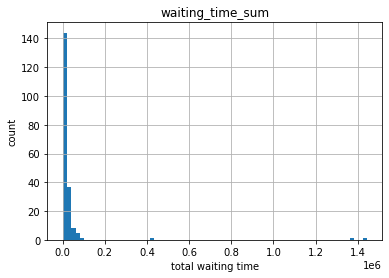

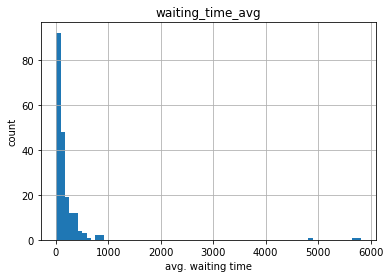

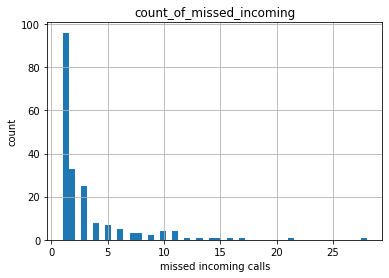

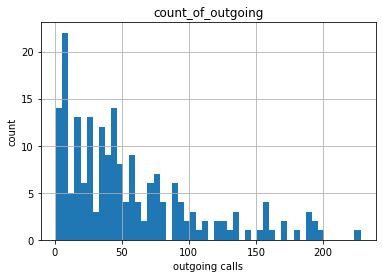

In [11]:
operator_pivot.hist('waiting_time_sum', bins=70)
plt.xlabel('total waiting time')
plt.ylabel('count')
plt.show()

operator_pivot.hist('waiting_time_avg', bins=70)
plt.xlabel('avg. waiting time')
plt.ylabel('count')
plt.show()

operator_pivot.hist('count_of_missed_incoming', bins=50)
plt.xlabel('missed incoming calls')
plt.ylabel('count')
plt.show()

operator_pivot.hist('count_of_outgoing', bins=50)
plt.xlabel('outgoing calls')
plt.ylabel('count')
plt.show()

calculate 75th, 90th and 95th precentiles for each of the metrics:

In [12]:
print("Waiting time sum percentiles: {}".format(np.percentile(operator_pivot['waiting_time_sum'], [75, 90, 95])))

print("Waiting time avg percentiles: {}".format(np.percentile(operator_pivot['waiting_time_avg'], [75, 90, 95]).round(1)))

print("Count of missed incoming percentiles: {}".format(np.percentile(operator_pivot['count_of_missed_incoming'], [75, 90, 95])))

print("Count of outgoing percentiles: {}".format(np.percentile(operator_pivot['count_of_outgoing'], [75, 90, 95])))


Waiting time sum percentiles: [21633.  38548.8 55085.9]
Waiting time avg percentiles: [218.7 377.9 522.3]
Count of missed incoming percentiles: [ 3.  8. 11.]
Count of outgoing percentiles: [ 76.  133.2 162.2]


Based on the histograms and percentiles, looks like we might want to exclude some outliers. Let's see how it will look like visually:

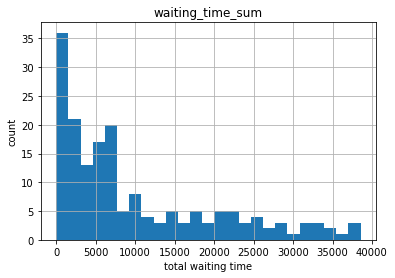

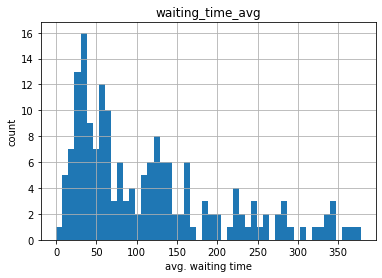

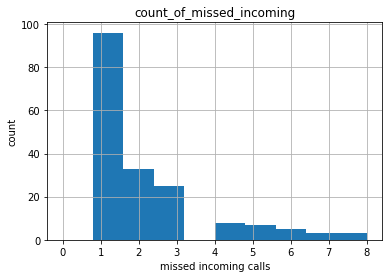

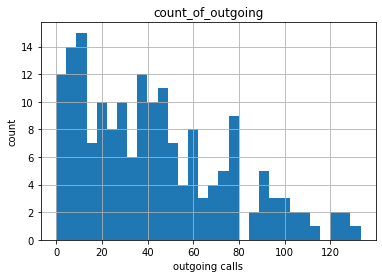

In [13]:
operator_pivot.hist('waiting_time_sum', bins=25, range=(0, np.percentile(operator_pivot['waiting_time_sum'], 90)))
plt.xlabel('total waiting time')
plt.ylabel('count')
plt.show()

operator_pivot.hist('waiting_time_avg', bins=50, range=(0, np.percentile(operator_pivot['waiting_time_avg'], 90)))
plt.xlabel('avg. waiting time')
plt.ylabel('count')
plt.show()

operator_pivot.hist('count_of_missed_incoming', bins=10, range=(0, np.percentile(operator_pivot['count_of_missed_incoming'], 90)))
plt.xlabel('missed incoming calls')
plt.ylabel('count')
plt.show()

operator_pivot.hist('count_of_outgoing', bins=30, range=(0, np.percentile(operator_pivot['count_of_outgoing'], 90)))
plt.xlabel('outgoing calls')
plt.ylabel('count')
plt.show()

After some thought process, while it looks like there are anomalies that skew our metrics and EDA, I decide not to remove them based on the assumption that those are exactly those we want to detect and identify as ineffective. 

### Identify ineffective operators
<a id="3"></a>
define a methodology to rank / bin the operators score for each of the metrics as a 1-100 score so that the higher the score the worst the operator is doing in the specific metric. <i> e.g. in the third metric it is more confusing than the others, since the lower the amount of calls the worse the operator is (for those that are supposed to make outgoing calls). In case the operator is not supposed to make such calls, we will avg. them only based on the two first metrics. </i>

In [14]:
#opposite scale for the outgoing which is worse if the number is lower
OldRange = (operator_pivot['count_of_outgoing'].max() - operator_pivot['count_of_outgoing'].min())  
NewRange = (100 - 0)  
operator_pivot['outgoing_count_score'] = (((operator_pivot['count_of_outgoing'] - operator_pivot['count_of_outgoing'].min()) * NewRange * -1) / OldRange).round(2) + 100

#normal 1-100 scale
operator_pivot['avg_waiting_time_score'] = (operator_pivot['waiting_time_avg']*100/operator_pivot['waiting_time_avg'].max()).round(2)
operator_pivot['missed_incoming_score'] = (operator_pivot['count_of_missed_incoming']*100/operator_pivot['count_of_missed_incoming'].max()).round(2)


operator_pivot.sort_values('count_of_outgoing', ascending=True)

,waiting_time_sum,waiting_time_avg,count_of_missed_incoming,count_of_outgoing,outgoing_count_score,avg_waiting_time_score,missed_incoming_score
operator_id,,,,,,,
905862,1165,30.657895,3,1,100.00,0.53,10.71
904344,63,21.000000,1,1,100.00,0.36,3.57
914440,575,28.750000,1,1,100.00,0.50,3.57
919206,7389,369.450000,7,1,100.00,6.36,25.00
937956,1029,17.150000,8,1,100.00,0.30,28.57
...,...,...,...,...,...,...,...
891410,33579,128.655172,2,191,16.30,2.22,7.14
885876,1369284,4838.459364,17,193,15.42,83.35,60.71
901880,50377,166.811258,10,194,14.98,2.87,35.71


plot 3 histograms to see how many operators fall within each rank (1-100) of the metrics we defined:

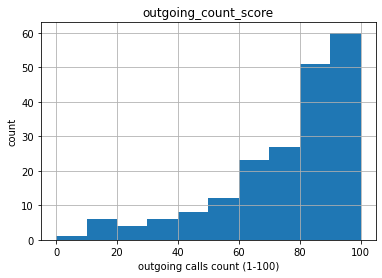

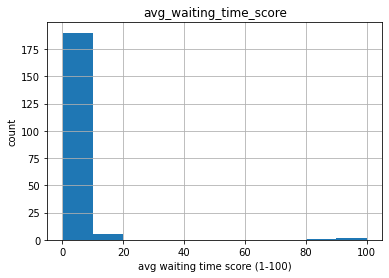

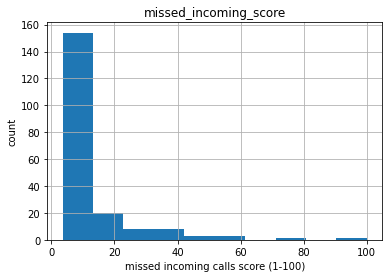

In [15]:
operator_pivot.hist('outgoing_count_score', bins=10)
plt.xlabel('outgoing calls count (1-100)')
plt.ylabel('count')
plt.show()

operator_pivot.hist('avg_waiting_time_score', bins=10)
plt.xlabel('avg waiting time score (1-100)')
plt.ylabel('count')
plt.show()

operator_pivot.hist('missed_incoming_score', bins=10)
plt.xlabel('missed incoming calls score (1-100)')
plt.ylabel('count')
plt.show()

The metric scores look fine apart from the outgoing one which is a bit concerning, since many operators fall within the 75+ score and have low amount of calls. However, this should be sufficient in case we use an average of the three metrics. 

Let's calculate the average of each operator for the three metrics:  

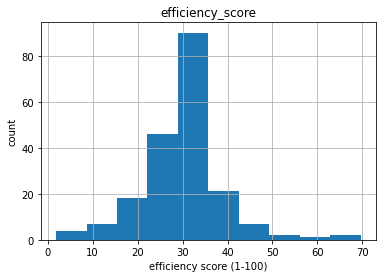

,waiting_time_sum,waiting_time_avg,count_of_missed_incoming,count_of_outgoing,outgoing_count_score,avg_waiting_time_score,missed_incoming_score,efficiency_score
operator_id,,,,,,,,
925922,423767,5805.027397,8,46,80.18,100.00,28.57,69.583333
885890,1443002,5703.565217,21,159,30.40,98.25,75.00,67.883333
913942,38198,282.948148,28,50,78.41,4.87,100.00,61.093333
885876,1369284,4838.459364,17,193,15.42,83.35,60.71,53.160000
940588,7663,112.691176,15,16,93.39,1.94,53.57,49.633333
919554,38358,456.642857,11,8,96.92,7.87,39.29,48.026667
944216,10443,117.337079,16,37,84.14,2.02,57.14,47.766667
940630,10046,164.688525,11,12,95.15,2.84,39.29,45.760000
944226,9397,106.784091,14,38,83.70,1.84,50.00,45.180000


In [16]:


operator_pivot['efficiency_score'] =  operator_pivot[['outgoing_count_score', 'avg_waiting_time_score', 'missed_incoming_score']].mean(axis=1)

operator_pivot.hist('efficiency_score', bins=10)
plt.xlabel('efficiency score (1-100)')
plt.ylabel('count')
plt.show()

#operator_pivot[operator_pivot['efficiency_score'] > 60]

operator_pivot.sort_values('efficiency_score', ascending=False).head(20)

    - add a column of is_ineffective and set to true all operators with avg. above the agreed upon threshold

In [18]:
print("Count of efficiency_score percentiles: {}".format(np.percentile(operator_pivot['efficiency_score'], [75, 90, 95])))

thres = np.percentile(operator_pivot['efficiency_score'], [90])

operator_pivot['is_ineffective'] = operator_pivot['efficiency_score'].apply(lambda x: True if x>thres else False)

Count of efficiency_score percentiles: [34.01833333 38.50233333 43.08116667]
[38.50233333]


In [19]:
operator_pivot

### Test statistical hypotheses
<a id="4"></a>


#### Average outgoing call duration between both plans is the same
* <b> Null hypotheses: </b> Average outgoing call duration of tarrif plans A, B & C  are  <u> similar. </u>
* <b> Alternative hypotheses: </b> Average outgoing call duration of tarrif plans A, B & C  are <u> differs. </u> 

Merge tariff plan into data:

In [34]:
merged = data.merge(clients_data, on='user_id', how='inner').reset_index(drop=True)

Create segmented data:

In [41]:
tariff_a = merged[(merged.tariff_plan == 'A')&(merged.direction == 'out')]['call_duration']
tariff_b = merged[(merged.tariff_plan == 'B')&(merged.direction == 'out')]['call_duration']
tariff_c = merged[(merged.tariff_plan == 'C')&(merged.direction == 'out')]['call_duration']

Start with a levene test (α=0.05) to see whether we have equal variance condition for the t-test:

In [45]:
from scipy import stats as st
print ("A&B:",st.levene(tariff_a, tariff_b, center='mean'))
print ("A&C:",st.levene(tariff_a, tariff_c, center='mean'))
print ("C&B:",st.levene(tariff_c, tariff_b, center='mean'))

A&B: LeveneResult(statistic=864.8530050904122, pvalue=6.001348028221442e-186)
A&C: LeveneResult(statistic=764.3822796995113, pvalue=6.622508353670863e-165)
C&B: LeveneResult(statistic=13.762715502325923, pvalue=0.00020797194121756273)


For the pair C&B - the p-value of the test is less than the threshold value of 0.05 and hence, we reject the null hypothesis and conclude that the sample groups do not have equal variance (and we will specify equal_var==False)

In [47]:
alpha = .05 # critical statistical significance level
                        # if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(
        tariff_a, 
        tariff_b,equal_var = True)

print('A&B p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 

A&B p-value:  5.886792134711496e-65
We reject the null hypothesis


In [48]:
alpha = .05 # critical statistical significance level
                        # if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(
        tariff_a, 
        tariff_c,equal_var = True)

print('A&C p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 

A&C p-value:  3.164111666853293e-58
We reject the null hypothesis


In [46]:
alpha = .05 # critical statistical significance level
                        # if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(
        tariff_c, 
        tariff_b,equal_var = False)

print('C&B p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 

C&B p-value:  0.12360639064872214
We can't reject the null hypothesis


We can't reject the null hypothesis that the average outgoing call duration for tariff plans C&B  are similar. Therefore, with confidence of 95% (alpha of 5% is strong enough and most commonly used for business purposes like we deal with in this analysis) conclude that they are similar. 

In regards to the pairs A&B and A&C - we do reject the null hypothesis that the average outgoing call duration for the two tariff plans is similar. Hence, with confidence of 95% (alpha of 5% is strong enough and most commonly used for business purposes like we deal with in this analysis) conclude that average outgoing call duration for the pairs A&B and A&C is different.  

### Conclusion
<a id="5"></a>

To sum it up, after a few tweaks we were able to create a formula and methodology to identify ineffective operators. While we decide to define the worst 10% as ineffective, this could easily be changed subjust to feedback from our supervisors. Also, given the fact we do not have details about the different plans, it is evident that the avg. outgoing call duration (which is usually a variable with a very strong correlation to revenue for telecom operators) differs for plan A compared to the two other tariff plans - B&C. However, with B&C, our data does not support that the avg. outgoing call duration is different. 




### Others
<a id="5"></a>
Useful readings: 

- double-checked about creating the is_efficient parameter - https://datatofish.com/if-condition-in-pandas-dataframe/
- reset_index documentation, critical and also improves readability in many cases -https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html 
- refresher of pivot with multiple functions - https://towardsdatascience.com/pivot-tables-cross-tabulation-data-aggregation-tools-in-python-dd6791dbe3cd
- numpy precentile function documentation - https://numpy.org/doc/stable/reference/generated/numpy.percentile.html
- stack overflow thread discussing how to create the 1-100 scale (used it to create the opposite formula) - https://stackoverflow.com/questions/929103/convert-a-number-range-to-another-range-maintaining-ratio
- lambda refresher - https://realpython.com/python-lambda/#:~:text=A%20Python%20lambda%20function%20behaves,function%20in%20regard%20to%20arguments.&text=The%20Python%20lambda%20function%20could,n%20set%20at%20definition%20time.